In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/233.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/118annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/231.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/207.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/115annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/123annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/209.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/203annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/202annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/215annotat

In [2]:
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential , Model
from keras.layers import Dense, LSTM, Dropout, Softmax, Bidirectional, Flatten
import math
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [5]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
filenames = next(os.walk(path))[2]
records = list()
annotations = list()
filenames.sort()

In [7]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)
    else:
        annotations.append(path + filename + file_extension)

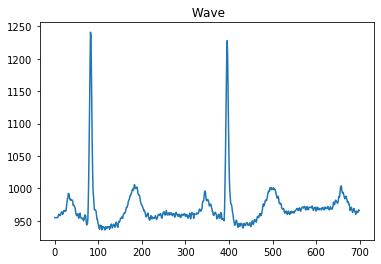

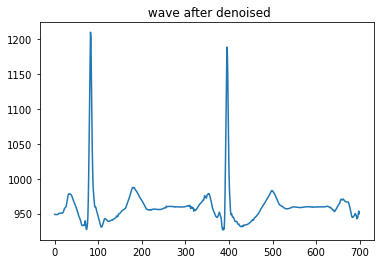

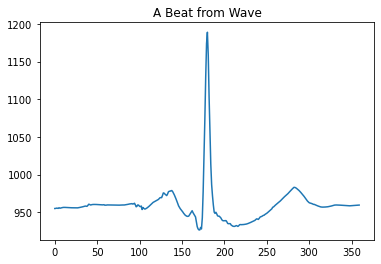

(100012, 360) (100012,)


In [8]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        plt.title(" Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    if r is 1:
        plt.title(" wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()
        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True
                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))

In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
print(np.shape(X))

(100012, 361)


In [10]:
X_train_df = pd.DataFrame(X)
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,963.374455,963.536949,964.756621,965.399062,966.017086,966.375099,966.610054,966.770207,966.863751,966.951485,...,962.278640,962.282842,962.301737,962.395261,962.294270,961.799296,963.125729,961.823215,962.056695,0.0
1,950.134075,950.900959,951.742885,951.389255,952.444730,952.698845,952.985557,953.265506,953.554840,953.878155,...,957.912677,957.910661,957.908414,957.887200,957.930868,958.046497,957.767864,957.935546,957.848457,0.0
2,956.855367,957.921859,958.970263,960.062874,961.063537,961.544535,961.778225,961.903495,961.914781,961.927284,...,962.793234,963.018453,963.291927,963.610334,963.801834,963.664744,964.690013,963.714316,963.719371,0.0
3,956.333844,956.469719,956.650190,956.840204,957.063040,957.289795,957.532154,957.763758,957.903596,958.002126,...,963.483037,963.849264,964.232722,964.751295,965.325454,965.385283,965.277388,965.949119,966.749783,0.0
4,950.051087,950.080657,950.899845,951.943309,952.584266,953.144752,953.758744,954.385010,955.116512,955.847917,...,962.082603,962.257165,962.430031,962.608560,962.787336,962.969444,963.152923,963.315874,963.472298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100007,960.091597,958.332371,959.228982,959.937280,960.462593,960.875403,961.311190,961.743369,962.152282,962.574638,...,964.516509,965.081464,965.657630,965.508808,965.080290,964.863438,964.607543,964.151499,963.933098,0.0
100008,960.158109,960.774672,961.122588,962.403698,963.542825,966.482368,966.960323,967.707577,968.022530,968.521270,...,963.553957,962.929216,962.408595,961.909285,961.207912,960.546289,959.842670,959.283797,959.529191,0.0
100009,959.520187,958.437111,959.105015,959.603769,960.050059,961.738668,962.600041,960.552121,957.583658,959.426743,...,968.586538,969.176431,969.713374,970.199836,970.198314,970.071392,969.631823,969.133521,969.677513,0.0
100010,957.960255,957.948389,959.213426,959.568639,959.893190,960.498387,961.169668,961.611360,961.984491,962.369367,...,974.808446,973.751860,972.810871,971.849649,970.724459,969.718156,968.525272,967.561324,968.065026,0.0


In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


In [12]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=42)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=42)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=42)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=42)
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [13]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


In [14]:
train, test = train_test_split(X_train_df, test_size=0.20)
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [15]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [16]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [17]:
print(train_x)

[[[1033.72758369]
  [1035.02365249]
  [1036.21428748]
  ...
  [ 969.49517529]
  [ 974.26526919]
  [ 971.60913182]]

 [[ 988.44794402]
  [ 995.89743783]
  [ 993.94626934]
  ...
  [1021.41281644]
  [1021.21691198]
  [1021.31455613]]

 [[ 983.52095499]
  [ 982.03269051]
  [ 981.22122322]
  ...
  [ 979.84118145]
  [ 979.837797  ]
  [ 979.70607301]]

 ...

 [[ 848.4537476 ]
  [ 848.38924671]
  [ 848.47105217]
  ...
  [ 863.5261889 ]
  [ 863.53172479]
  [ 863.05418747]]

 [[ 936.24028341]
  [ 936.49404491]
  [ 937.14427351]
  ...
  [ 980.35449435]
  [ 980.28676913]
  [ 979.94366339]]

 [[1038.52822002]
  [1041.25414802]
  [1042.29113859]
  ...
  [1055.77327694]
  [1055.41206452]
  [1055.67364818]]]


In [18]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(360,1))))
model1.add(Bidirectional(LSTM(units=10, return_sequences=True, activation='tanh')))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(35))
model1.add(Dense(5))
model1.add(Softmax())

2022-06-21 08:48:12.912633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 08:48:13.062390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 08:48:13.063734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 08:48:13.066364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
history  = model1.fit(train_x, train_y, batch_size=128, epochs=60, verbose=1, validation_data=(test_x, test_y))

2022-06-21 08:48:16.035594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-06-21 08:48:22.073046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 21s 89ms/step - loss: 1.6987 - accuracy: 0.2421 - val_loss: 1.5335 - val_accuracy: 0.2926
Epoch 2/60
157/157 [==============================] - 13s 80ms/step - loss: 1.5131 - accuracy: 0.3200 - val_loss: 1.4579 - val_accuracy: 0.4624
Epoch 3/60
157/157 [==============================] - 13s 81ms/step - loss: 1.3291 - accuracy: 0.4778 - val_loss: 1.0446 - val_accuracy: 0.6428
Epoch 4/60
157/157 [==============================] - 13s 81ms/step - loss: 0.9463 - accuracy: 0.6709 - val_loss: 1.2173 - val_accuracy: 0.4620
Epoch 5/60
157/157 [==============================] - 13s 81ms/step - loss: 0.8276 - accuracy: 0.7229 - val_loss: 0.6819 - val_accuracy: 0.7938
Epoch 6/60
157/157 [==============================] - 13s 82ms/step - loss: 0.6732 - accuracy: 0.7876 - val_loss: 0.5154 - val_accuracy: 0.8366
Epoch 7/60
157/157 [==============================] - 13s 80ms/step - loss: 0.5889 - accuracy: 0.8141 - val_loss: 0.5431 - val_accuracy: 0.8510
Epo

In [21]:
score1 = model1.evaluate(test_x, test_y)
print(score1[1])

157/157 [==============================] - 5s 30ms/step - loss: 0.1015 - accuracy: 0.9642
0.9642000198364258


In [22]:
def speci(kcm):
    total=sum(sum(kcm))
    sensitivity1 = kcm[0,0]/(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4])
    print('Sensitivity of  Non-ecotic beats (normal beat) ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4]))
    print('Specificity of  Non-ecotic beats (normal beat) ', specificity1)
    sensitivity1 = kcm[1,1]/(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4])
    print('Sensitivity of  Supraventricular ectopic beats ', sensitivity1 )
    specificity1 = (kcm[0,0]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4]))
    print('Specificity of  Supraventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[2,2]/(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4])
    print('Sensitivity of  Ventricular ectopic beats  ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[0,0]+kcm[3,3]+kcm[4,4])/(total-(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4]))
    print('Specificity of  Ventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[3,3]/(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4])
    print('Sensitivity of  Fusion Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[0,0]+kcm[4,4])/(total-(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4]))
    print('Specificity of  Fusion Beats ', specificity1)
    sensitivity1 = kcm[4,4]/(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4])
    print('Sensitivity of  Unknown Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[0,0])/(total-(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4]))
    print('Specificity of  Unknown Beats ', specificity1)
    

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model1.predict(test_x)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print(confusion_mtx)
print(classification_report(Y_true, Y_pred_classes))
speci(confusion_mtx)

[[ 918    4    4   49   10]
 [   4 1025    0    3    5]
 [   2    0  980    3    0]
 [  57    0    5  946    1]
 [   8   10    5    9  952]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       985
           1       0.99      0.99      0.99      1037
           2       0.99      0.99      0.99       985
           3       0.94      0.94      0.94      1009
           4       0.98      0.97      0.98       984

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9319796954314721
Specificity of  Non-ecotic beats (normal beat)  0.9721046077210461
Sensitivity of  Supraventricular ectopic beats  0.9884281581485053
Specificity of  Supraventricular ectopic beats  0.9578602069139541
Sensitivity of  Ventricular ectopic beats   0.9949238578680203
Specificity of  Ventricular ectopic bea

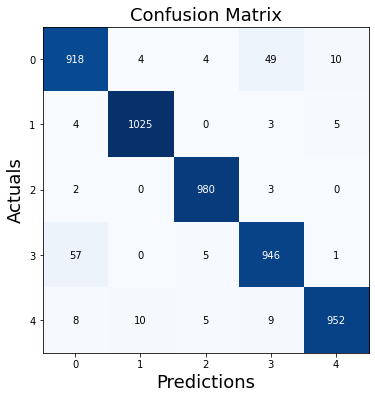

In [24]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_mtx, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [25]:
model_feat = Model(inputs=model1.input,outputs=model1.get_layer('flatten').output)
feat_train = model_feat.predict(train_x)
print(feat_train.shape)
feat_test = model_feat.predict(test_x)
print(feat_test.shape)

(20000, 7200)
(5000, 7200)


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time
start0 = time.time()
sc = StandardScaler()
X_train = sc.fit_transform(feat_train)
X_test = sc.transform(feat_test)
lda = LDA(n_components=4)
lda_X_train = lda.fit_transform(X_train,np.argmax(train_y,axis=1))
lda_X_test = lda.transform(X_test)
stop0=time.time()
print(f"Training time: {stop0 - start0}s")

Training time: 385.8966782093048s


In [27]:
print(lda_X_train.shape)
print(lda_X_test.shape)

(20000, 4)
(5000, 4)


In [28]:
import time

In [29]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
t0=time.time()
svm.fit(lda_X_train,np.argmax(train_y,axis=1))
t1=time.time()
print(f"Training time: {t1-t0}s")

Training time: 0.13754558563232422s


In [30]:
t2=time.time()
Pred_labels = svm.predict(lda_X_test)
t3=time.time()
print(Pred_labels )
print(f"Testing time: {t3-t1}s")

[4 2 3 ... 4 2 4]
Testing time: 5.395446300506592s


In [31]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,Pred_labels)
print("Accuracy:",accuracy)

Accuracy: 0.9432


In [32]:
cm = confusion_matrix(target_test, Pred_labels) 
print(cm)
print(classification_report(target_test, Pred_labels))
speci(cm)

[[ 917    6    9   43   10]
 [  17 1015    0    2    3]
 [  20    2  955    7    1]
 [  59    1    7  939    3]
 [  75    7    2   10  890]]
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88       985
         1.0       0.98      0.98      0.98      1037
         2.0       0.98      0.97      0.98       985
         3.0       0.94      0.93      0.93      1009
         4.0       0.98      0.90      0.94       984

    accuracy                           0.94      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.95      0.94      0.94      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9309644670050762
Specificity of  Non-ecotic beats (normal beat)  0.9462017434620175
Sensitivity of  Supraventricular ectopic beats  0.9787849566055931
Specificity of  Supraventricular ectopic beats  0.9338884683320716
Sensitivity of  Ventricular ectopic beats   0.9695431472081218
Specificity of  Ventricular ectopic bea

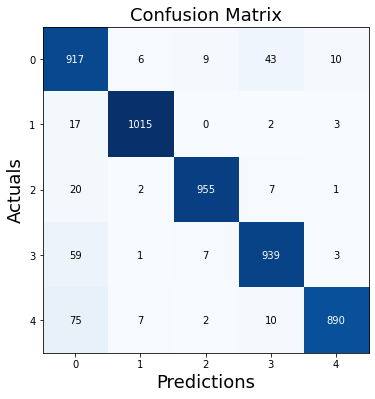

In [33]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
t4=time.time()
knn.fit(lda_X_train,np.argmax(train_y,axis=1))
t5=time.time()
print(f"Training time: {t5-t4}s")

Training time: 0.04190254211425781s


In [35]:
t6=time.time()
knn_labels = knn.predict(lda_X_test)
t7=time.time()
print(knn_labels )
print(f"Testing time: {t7-t6}s")

[4 2 3 ... 4 2 4]
Testing time: 0.19644451141357422s


In [36]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,knn_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, knn_labels) 
print(cm)
print(classification_report(target_test, knn_labels))
speci(cm)

Accuracy: 0.9544
[[ 905   13   12   42   13]
 [  10 1020    0    2    5]
 [   7    3  966    6    3]
 [  33    5   11  954    6]
 [  18   18    9   12  927]]
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       985
         1.0       0.96      0.98      0.97      1037
         2.0       0.97      0.98      0.97       985
         3.0       0.94      0.95      0.94      1009
         4.0       0.97      0.94      0.96       984

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9187817258883249
Specificity of  Non-ecotic beats (normal beat)  0.9631382316313823
Sensitivity of  Supraventricular ectopic beats  0.9836065573770492
Specificity of  Supraventricular ectopic beats  0.9467575069391875
Sensitivity of  Ventricular ectopic beats   0.9807106598984772
Specificity of  Ventri

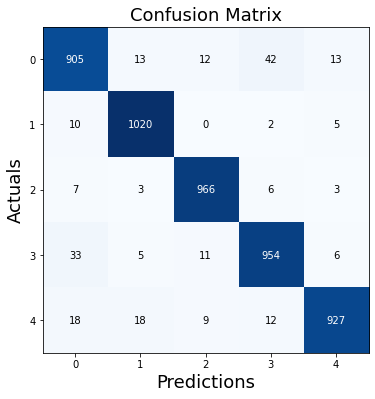

In [37]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [38]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
t8=time.time()
svclassifier.fit(lda_X_train,np.argmax(train_y,axis=1))
t9=time.time()
print(f"Training time: {t9-t8}s")

Training time: 0.22609353065490723s


In [39]:
t10=time.time()
svm_labels = svclassifier.predict(lda_X_test)
t11=time.time()
print(svm_labels )
print(f"Testing time: {t11-t10}s")

[4 2 3 ... 4 2 4]
Testing time: 0.07710909843444824s


In [40]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.9502
[[ 897   14   13   49   12]
 [   9 1020    0    2    6]
 [   5    7  962    8    3]
 [  39    7    9  947    7]
 [  20   14   10   15  925]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       985
         1.0       0.96      0.98      0.97      1037
         2.0       0.97      0.98      0.97       985
         3.0       0.93      0.94      0.93      1009
         4.0       0.97      0.94      0.96       984

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9106598984771573
Specificity of  Non-ecotic beats (normal beat)  0.9599003735990037
Sensitivity of  Supraventricular ectopic beats  0.9836065573770492
Specificity of  Supraventricular ectopic beats  0.9414584910421397
Sensitivity of  Ventricular ectopic beats   0.9766497461928934
Specificity of  Ventri

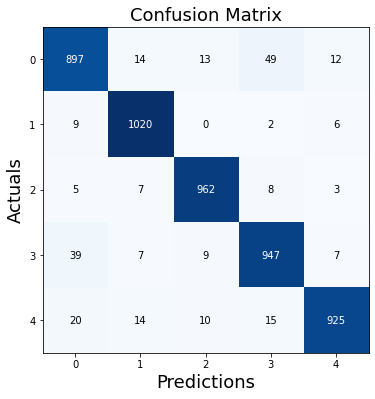

In [41]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [42]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
t12=time.time()
svclassifier.fit(lda_X_train,np.argmax(train_y,axis=1))
t13=time.time()
print(f"Training time: {t13-t12}s")

Training time: 0.5098118782043457s


In [43]:
t14=time.time()
svm_labels = svclassifier.predict(lda_X_test)
t15=time.time()
print(svm_labels )
print(f"Testing time: {t15-t14}s")

[4 2 3 ... 4 2 4]
Testing time: 0.146622896194458s


In [44]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.8946
[[ 907   16   12   21   29]
 [  24 1007    3    1    2]
 [  60   14  901    5    5]
 [ 154   14    7  821   13]
 [  89   33   17    8  837]]
              precision    recall  f1-score   support

         0.0       0.74      0.92      0.82       985
         1.0       0.93      0.97      0.95      1037
         2.0       0.96      0.91      0.94       985
         3.0       0.96      0.81      0.88      1009
         4.0       0.94      0.85      0.90       984

    accuracy                           0.89      5000
   macro avg       0.91      0.89      0.90      5000
weighted avg       0.91      0.89      0.90      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9208121827411168
Specificity of  Non-ecotic beats (normal beat)  0.8881693648816936
Sensitivity of  Supraventricular ectopic beats  0.9710703953712633
Specificity of  Supraventricular ectopic beats  0.8745899571032046
Sensitivity of  Ventricular ectopic beats   0.9147208121827411
Specificity of  Ventri

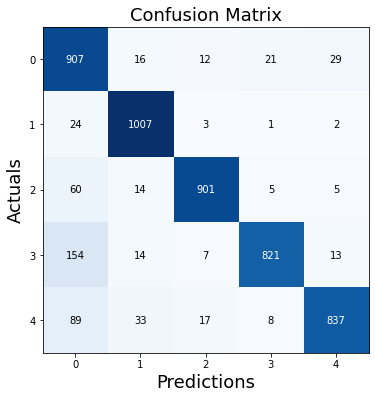

In [45]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
t16=time.time()
gnb.fit(lda_X_train,np.argmax(train_y,axis=1))
t17=time.time()
print(f"Training time: {t17-t16}s")

Training time: 0.010645389556884766s


In [47]:
t18=time.time()
gnb_labels = gnb.predict(lda_X_test)
t19=time.time()
print(gnb_labels )
print(f"Testing time: {t19-t18}s")

[4 2 3 ... 4 2 4]
Testing time: 0.0034570693969726562s


In [48]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,gnb_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, gnb_labels) 
print(cm)
print(classification_report(target_test, gnb_labels))
speci(cm)

Accuracy: 0.9512
[[ 945    7    6   20    7]
 [  13 1019    0    1    4]
 [  20    1  955    6    3]
 [  69    2    7  925    6]
 [  51   11    4    6  912]]
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91       985
         1.0       0.98      0.98      0.98      1037
         2.0       0.98      0.97      0.98       985
         3.0       0.97      0.92      0.94      1009
         4.0       0.98      0.93      0.95       984

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9593908629441624
Specificity of  Non-ecotic beats (normal beat)  0.9491905354919054
Sensitivity of  Supraventricular ectopic beats  0.982642237222758
Specificity of  Supraventricular ectopic beats  0.9429724955841534
Sensitivity of  Ventricular ectopic beats   0.9695431472081218
Specificity of  Ventric

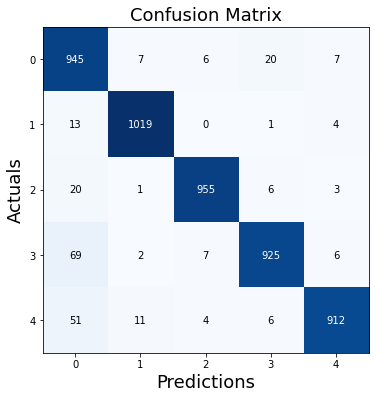

In [49]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [50]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
t20=time.time()
dt.fit(lda_X_train,np.argmax(train_y,axis=1))
t21=time.time()
print(f"Training time: {t21-t20}s")

Training time: 0.0548250675201416s


In [51]:
t22=time.time()
dt_labels = dt.predict(lda_X_test)
t23=time.time()
print(dt_labels )
print(f"Testing time: {t23-t22}s")

[4 2 3 ... 4 2 4]
Testing time: 0.0012786388397216797s


In [52]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,dt_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, dt_labels) 
print(cm)
print(classification_report(target_test, dt_labels))
speci(cm)

Accuracy: 0.9462
[[ 869   17   12   47   40]
 [   8 1017    0    3    9]
 [   4    1  932   24   24]
 [  22    3    5  966   13]
 [   4   17    3   13  947]]
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92       985
         1.0       0.96      0.98      0.97      1037
         2.0       0.98      0.95      0.96       985
         3.0       0.92      0.96      0.94      1009
         4.0       0.92      0.96      0.94       984

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8822335025380711
Specificity of  Non-ecotic beats (normal beat)  0.961892901618929
Sensitivity of  Supraventricular ectopic beats  0.9807135969141755
Specificity of  Supraventricular ectopic beats  0.9371688115064345
Sensitivity of  Ventricular ectopic beats   0.9461928934010152
Specificity of  Ventric

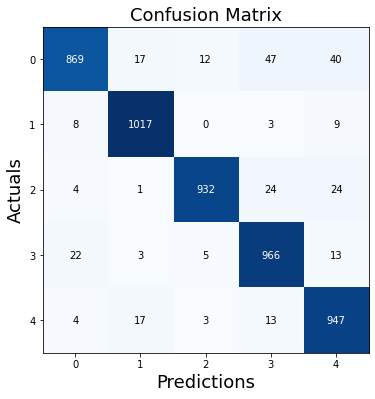

In [53]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [54]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
t24=time.time()
rfc.fit(lda_X_train,np.argmax(train_y,axis=1))
t25=time.time()
print(f"Training time: {t25-t24}s")

Training time: 2.3435657024383545s


In [55]:
t26=time.time()
rfc_labels = rfc.predict(lda_X_test)
t27=time.time()
print(rfc_labels )
print(f"Testing time: {t27-t26}s")

[4 2 3 ... 4 2 4]
Testing time: 0.04782724380493164s


In [56]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,rfc_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, rfc_labels) 
print(cm)
print(classification_report(target_test, rfc_labels))
speci(cm)

Accuracy: 0.954
[[ 897   10   14   40   24]
 [   8 1020    2    1    6]
 [   8    2  951    6   18]
 [  25    8    9  961    6]
 [  10   18    4   11  941]]
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       985
         1.0       0.96      0.98      0.97      1037
         2.0       0.97      0.97      0.97       985
         3.0       0.94      0.95      0.95      1009
         4.0       0.95      0.96      0.95       984

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9106598984771573
Specificity of  Non-ecotic beats (normal beat)  0.9646326276463263
Sensitivity of  Supraventricular ectopic beats  0.9836065573770492
Specificity of  Supraventricular ectopic beats  0.9462528387585163
Sensitivity of  Ventricular ectopic beats   0.965482233502538
Specificity of  Ventricu

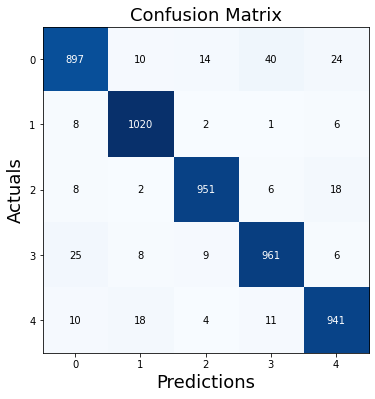

In [57]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [58]:
target= X_train_df[X_train_df.shape[1]-1]
feature = X_train_df.iloc[:,:X_train_df.shape[1]-1].values
feature = feature.reshape(len(feature), feature.shape[1],1)

In [59]:
feat = model_feat.predict(feature)
X_train = sc.fit_transform(feat)
lda = LDA(n_components=4)
lda_train = lda.fit_transform(X_train, target)
print(lda_train.shape)


(25000, 4)


In [60]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(rfc, lda_train, target, scoring='accuracy', cv=10)
print(score)

[0.9944 0.9956 0.9936 0.9956 0.998  0.9968 0.9952 0.9968 0.9964 0.9964]


In [61]:
print("Avg :",np.average(score))

Avg : 0.99588
